# Phase 2: Dynamic Programming Walkthrough

This notebook is a step-by-step walkthrough of the Phase 2 DP analysis.
It covers the full pipeline from data calibration through policy interpretation,
documents the key analytical decisions, and presents the findings.

**Sections:**
1. Setup & Load Parameters
2. MDP Formulation Recap
3. Calibration: How We Estimated Parameters
4. The Category Question: Staples vs. Discretionary
5. Daily vs. Weekly Resolution
6. DP Solver: State Space & Convergence
7. Policy Analysis: What the DP Learned
8. Value Function Interpretation
9. Q-Gap Diagnostics
10. Baseline Comparisons
11. Memory Sensitivity Analysis
12. Key Takeaways

## 1. Setup & Load Parameters

In [1]:
from dataclasses import replace
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

import yaml

from discount_engine.core.params import load_mdp_params
from discount_engine.dp.discretization import (
    MAX_DP_CATEGORIES, enumerate_all_states, enumerate_live_states,
    resolve_churn_grid, resolve_churn_labels, terminal_state,
    temporary_bucket_grids, decode_state,
)
from discount_engine.dp.quality_checks import run_quality_checks
from discount_engine.dp.transitions import enumerate_transition_distribution
from discount_engine.dp.value_iteration import ValueIterationConfig, solve_value_iteration

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"figure.dpi": 130, "figure.figsize": (10, 5)})

# Detect project root (works whether run from notebooks/ or project root)
_cwd = Path.cwd()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
DATA_DIR = PROJECT_ROOT / "data" / "processed"
PARAMS_PATH = DATA_DIR / "mdp_params.yaml"

# --- Key run directories ---
# v3: weekly resolution, mixed categories, beta_m_floor=0.10
RUN_V3_FLOOR = PROJECT_ROOT / "runs" / "dp" / "20260218_084945_weekly_mixed_v3_floor"
# v3 without floor (beta_m_floor=None): pure fitted parameters
RUN_V3_NOFLOOR = PROJECT_ROOT / "runs" / "dp" / "20260218_083313_weekly_mixed_v3"

params = load_mdp_params(PARAMS_PATH)
N = len(params.categories)
print(f"Categories (N={N}):")
for i, c in enumerate(params.categories):
    print(f"  {i}: {c.name} — price=${c.price:.2f}, beta_0={c.beta_0:.3f}")
print(f"\nbeta_p={params.beta_p:.4f}, beta_l={params.beta_l:.4f}, beta_m={params.beta_m:.4f}")
print(f"alpha={params.alpha:.2f}, eta={params.eta:.4f}, c0={params.c0:.3f}")
print(f"delta={params.delta:.2f}, gamma={params.gamma:.2f}")
if params.metadata:
    print(f"\ntime_resolution: {params.metadata.get('time_resolution', 'daily')}")
    print(f"beta_m_floor: {params.metadata.get('beta_m_floor')}")
    print(f"beta_m_floor_active: {params.metadata.get('beta_m_floor_active')}")

Categories (N=3):
  0: FLUID MILK PRODUCTS — price=$2.49, beta_0=1.498
  1: ICE CREAM/MILK/SHERBTS — price=$2.59, beta_0=-0.829
  2: FROZEN PIZZA — price=$2.00, beta_0=-0.736

beta_p=0.3962, beta_l=0.0276, beta_m=0.1000
alpha=0.00, eta=0.0099, c0=0.050
delta=0.30, gamma=0.99

time_resolution: weekly
beta_m_floor: 0.1
beta_m_floor_active: True


/Users/eseide/.pyenv/versions/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. MDP Formulation Recap

The MDP models a retailer choosing which product category to promote each period.

**State** $s = (c, \mathbf{m}, \boldsymbol{\ell})$:
- $c$ — churn propensity bucket (Engaged / At-Risk / Lapsing)
- $\mathbf{m} = (m_1, \ldots, m_N)$ — per-category memory of past promotions (EWMA)
- $\boldsymbol{\ell} = (\ell_1, \ldots, \ell_N)$ — per-category recency since last purchase

**Action** $a \in \{0, 1, \ldots, N\}$: promote category $a$ (0 = no promotion).

**Transition dynamics:**
1. Effective price: $p^{\text{eff}}_i = p_i \cdot (1 - \delta \cdot \mathbb{1}[a = i])$
2. Purchase probability: $P(\text{buy}_i) = \sigma\bigl(\beta_{0,i} + \beta_p \cdot d_i - \beta_\ell \cdot \ell_i - \beta_m \cdot m_i\bigr)$
3. Memory update: $m_i' = \alpha \cdot m_i + (1 - \alpha) \cdot d_i \cdot \mathbb{1}[a = i]$
4. Recency update: $\ell_i' = 0$ if purchased, else $\ell_i + 1$
5. Churn update: $c' = c + \eta \cdot (1 - \text{any purchase})$

**Reward:** $R(s, a) = \sum_i P(\text{buy}_i) \cdot p^{\text{eff}}_i$

The deal signal $d_i$ uses the `price_delta_dollars` contract: $d_i = p_i \cdot \delta$ when promoted.

## 3. Calibration: How We Estimated Parameters

Parameters are calibrated from the Dunnhumby "Complete Journey" dataset (2,500 households, ~2 years).

**Key calibration choices:**
- **Deal signal contract:** `price_delta_dollars` — the deal signal is $p \cdot \delta$ in dollars, ensuring the logistic regression and DP use the same units.
- **Time resolution:** Weekly aggregation — daily data made churn/recency dynamics invisible (see Section 5).
- **Categories:** Explicit selection of FLUID MILK + ICE CREAM + FROZEN PIZZA (see Section 4).
- **Alpha selection:** Grid search over $\alpha \in \{0.0, 0.1, \ldots, 0.95\}$ using time-based validation split.
- **Memory floor:** `beta_m_floor=0.10` imposed as sensitivity knob (see Section 11).

In [2]:
# Parameter summary table
param_df = pd.DataFrame({
    "Parameter": ["beta_p (deal uplift)", "beta_l (recency penalty)",
                  "beta_m (memory penalty)", "alpha (memory decay)",
                  "eta (churn slope)", "c0 (base churn)",
                  "delta (discount rate)", "gamma (discount factor)"],
    "Value": [f"{params.beta_p:.4f}", f"{params.beta_l:.4f}",
              f"{params.beta_m:.4f}", f"{params.alpha:.2f}",
              f"{params.eta:.4f}", f"{params.c0:.3f}",
              f"{params.delta:.2f}", f"{params.gamma:.2f}"],
    "Interpretation": [
        "Each $1 deal signal adds 0.40 logit to purchase probability",
        "Each week since last purchase subtracts 0.028 logit",
        f"Imposed floor (fitted: 0.006); penalizes repeated promotion",
        "No memory decay — each promotion signal lasts exactly one period",
        "Churn propensity increases 0.01 per no-purchase week",
        "Baseline churn for Engaged bucket (clamped from 0.49 raw)",
        "Promoted price is 70% of shelf price",
        "~100 week effective planning horizon",
    ]
})
display(param_df.style.hide(axis='index').set_caption("Calibrated MDP Parameters (v3)"))

Parameter,Value,Interpretation
beta_p (deal uplift),0.3962,Each $1 deal signal adds 0.40 logit to purchase probability
beta_l (recency penalty),0.0276,Each week since last purchase subtracts 0.028 logit
beta_m (memory penalty),0.1000,Imposed floor (fitted: 0.006); penalizes repeated promotion
alpha (memory decay),0.00,No memory decay — each promotion signal lasts exactly one period
eta (churn slope),0.0099,Churn propensity increases 0.01 per no-purchase week
c0 (base churn),0.050,Baseline churn for Engaged bucket (clamped from 0.49 raw)
delta (discount rate),0.30,Promoted price is 70% of shelf price
gamma (discount factor),0.99,~100 week effective planning horizon


In [3]:
from scipy.special import expit

cat_rows = []
for c in params.categories:
    p_base = expit(c.beta_0)
    deal = c.price * params.delta
    p_promo = expit(c.beta_0 + params.beta_p * deal)
    cat_rows.append({
        "Category": c.name,
        "Price": f"${c.price:.2f}",
        "beta_0": f"{c.beta_0:.3f}",
        "P(buy) baseline": f"{p_base:.1%}",
        "P(buy) promoted": f"{p_promo:.1%}",
        "Uplift": f"+{p_promo - p_base:.1%}",
        "Deal signal ($)": f"${deal:.2f}",
    })
cat_df = pd.DataFrame(cat_rows)
display(cat_df.style.hide(axis='index').set_caption("Category Profiles"))

Category,Price,beta_0,P(buy) baseline,P(buy) promoted,Uplift,Deal signal ($)
FLUID MILK PRODUCTS,$2.49,1.498,81.7%,85.7%,+4.0%,$0.75
ICE CREAM/MILK/SHERBTS,$2.59,-0.829,30.4%,37.3%,+6.9%,$0.78
FROZEN PIZZA,$2.00,-0.736,32.4%,37.8%,+5.4%,$0.60


## 4. The Category Question: Staples vs. Discretionary

The original Phase 2 calibration used the 3 highest-volume categories: **Soft Drinks**, **Fluid Milk**, and **Baked Bread**. These are all high-frequency staples — customers buy them almost every trip.

This produced a policy that was mathematically optimal but economically trivial: "don't promote staples" (6.8% promotion rate, only 2 of 4 actions used). The DP correctly identified that promoting items people already buy is mostly cannibalization.

We switched to a **mixed category set**:
- **Fluid Milk** (staple, `beta_0 = 1.50`): ~82% baseline purchase probability
- **Ice Cream** (discretionary, `beta_0 = -0.83`): ~30% baseline — genuinely responsive to promotion
- **Frozen Pizza** (impulse, `beta_0 = -0.74`): ~32% baseline — deal-driven

This creates the tension the model needs: the staple sells itself, the discretionary items genuinely respond to promotion, and the policy has a real targeting choice.

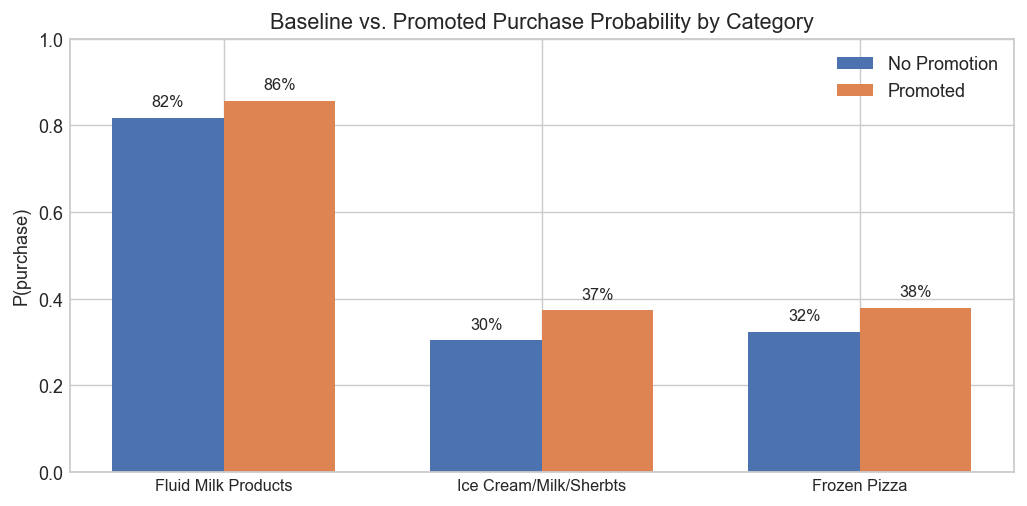

In [4]:
# Visual: baseline purchase probability comparison
fig, ax = plt.subplots(figsize=(8, 4))
names = [c.name.title() for c in params.categories]
baselines = [float(expit(c.beta_0)) for c in params.categories]
promos = [float(expit(c.beta_0 + params.beta_p * c.price * params.delta)) for c in params.categories]

x = np.arange(len(names))
width = 0.35
bars1 = ax.bar(x - width/2, baselines, width, label="No Promotion", color="#4C72B0")
bars2 = ax.bar(x + width/2, promos, width, label="Promoted", color="#DD8452")

ax.set_ylabel("P(purchase)")
ax.set_title("Baseline vs. Promoted Purchase Probability by Category")
ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=9)
ax.legend()
ax.set_ylim(0, 1.0)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f"{bar.get_height():.0%}", ha="center", va="bottom", fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f"{bar.get_height():.0%}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

## 5. Daily vs. Weekly Resolution

The original calibration used **daily** time steps. This made churn and recency dynamics invisible:

| Parameter | Daily | Weekly | Why it matters |
|-----------|-------|--------|----------------|
| `raw_c0` | 0.886 | 0.491 | Daily: "didn't shop today" (normal). Weekly: "didn't shop this week" (signal). |
| `eta` | 0.003/day | 0.010/week | Daily: 32 days to move one churn bucket. Weekly: ~5 weeks. |
| `beta_l` | 0.007 | 0.028 | 4× larger — recency now meaningfully affects purchase probability |
| Effective horizon | ~100 days (~3 months) | ~100 weeks (~2 years) | Weekly resolution gives a much longer planning perspective |

At weekly resolution, a no-purchase week is a genuine disengagement signal rather than a routine non-shopping day.

See `specs/05_staple_daily_resolution_findings.md` for detailed evidence.

## 6. DP Solver: State Space & Convergence

In [5]:
# Load solver config
solver_yaml = PROJECT_ROOT / "configs" / "dp" / "solver.yaml"
with open(solver_yaml) as f:
    solver_cfg = yaml.safe_load(f)

MEMORY_GRID = solver_cfg["memory_grid"]
RECENCY_GRID = solver_cfg["recency_grid"]

with temporary_bucket_grids(
    memory_grid=np.array(MEMORY_GRID),
    recency_grid=np.array(RECENCY_GRID),
):
    churn_grid = resolve_churn_grid(params)
    churn_labels = resolve_churn_labels(params)
    live_states = list(enumerate_live_states(N, churn_grid=churn_grid))
    all_states = list(enumerate_all_states(N, churn_grid=churn_grid))
    print(f"Memory grid: {MEMORY_GRID}")
    print(f"Recency grid: {RECENCY_GRID}")
    print(f"Churn grid: {churn_grid} — {churn_labels}")
    print(f"\nLive states: {len(live_states)}")
    print(f"All states (incl. terminal): {len(all_states)}")
    print(f"Actions: {N + 1} (0=No Promo, 1=Promo {params.categories[0].name}, ...")
    print(f"          ... {N}=Promo {params.categories[N-1].name})")

Memory grid: [0.0, 0.9, 2.0]
Recency grid: [1.0, 4.0]
Churn grid: (0.05, 0.09999999999999976, 0.5) — ('Engaged (low churn risk)', 'At-Risk (medium churn risk)', 'Lapsing (high churn risk)')

Live states: 648
All states (incl. terminal): 649
Actions: 4 (0=No Promo, 1=Promo FLUID MILK PRODUCTS, ...
          ... 3=Promo FROZEN PIZZA)


In [6]:
# Solve value iteration
vi_config = ValueIterationConfig(
    gamma=solver_cfg["gamma"],
    epsilon=solver_cfg["epsilon"],
    max_iters=solver_cfg["max_iters"],
)

with temporary_bucket_grids(
    memory_grid=np.array(MEMORY_GRID),
    recency_grid=np.array(RECENCY_GRID),
):
    result = solve_value_iteration(params, config=vi_config)

print(f"Converged: {result.converged}")
print(f"Iterations: {result.iterations}")
print(f"Final residual: {result.final_bellman_residual:.2e}")

Converged: True
Iterations: 1304
Final residual: 9.82e-09


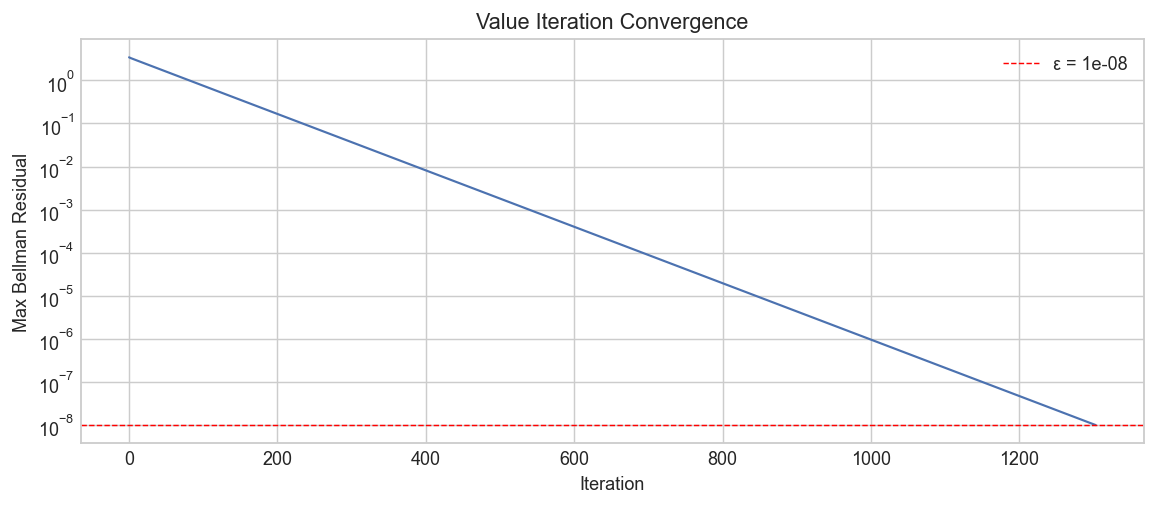

In [7]:
# Convergence plot
fig, ax = plt.subplots(figsize=(9, 4))
history = result.max_delta_history
ax.semilogy(range(len(history)), history, linewidth=1.2, color="#4C72B0")
ax.axhline(vi_config.epsilon, color="red", linestyle="--", linewidth=0.8, label=f"ε = {vi_config.epsilon:.0e}")
ax.set_xlabel("Iteration")
ax.set_ylabel("Max Bellman Residual")
ax.set_title("Value Iteration Convergence")
ax.legend()
plt.tight_layout()
plt.show()

## 7. Policy Analysis: What the DP Learned

The optimal policy reveals a clear **state-dependent promotion strategy**:
- **Lapsing customers** → promote Milk (highest baseline demand, most likely to generate a purchase and reset churn)
- **Engaged / At-Risk** → promote Ice Cream (highest price, best revenue per promotion)
- **The healthiest Engaged states** → no promotion (customer is already buying)

In [8]:
# Build state-level policy table
with temporary_bucket_grids(
    memory_grid=np.array(MEMORY_GRID),
    recency_grid=np.array(RECENCY_GRID),
):
    churn_grid = resolve_churn_grid(params)
    live = list(enumerate_live_states(N, churn_grid=churn_grid))
    churn_labels_tuple = resolve_churn_labels(params)

rows = []
action_names = ["No Promo"] + [f"Promo {c.name}" for c in params.categories]
for s in live:
    action = int(result.policy[s])
    value = float(result.values[s])
    cb = s.churn_bucket
    label = churn_labels_tuple[cb] if cb < len(churn_labels_tuple) else f"Bucket {cb}"
    rows.append({
        "state_id": str(s),
        "churn_bucket": cb,
        "churn_label": label,
        "memory_mean": float(np.mean(s.memory_buckets)),
        "recency_mean": float(np.mean(s.recency_buckets)),
        "action": action,
        "action_name": action_names[action],
        "value": value,
    })
policy_df = pd.DataFrame(rows)
print(f"Total live states: {len(policy_df)}")
print(f"Promotion rate: {(policy_df['action'] > 0).mean():.1%}")

Total live states: 648
Promotion rate: 88.7%


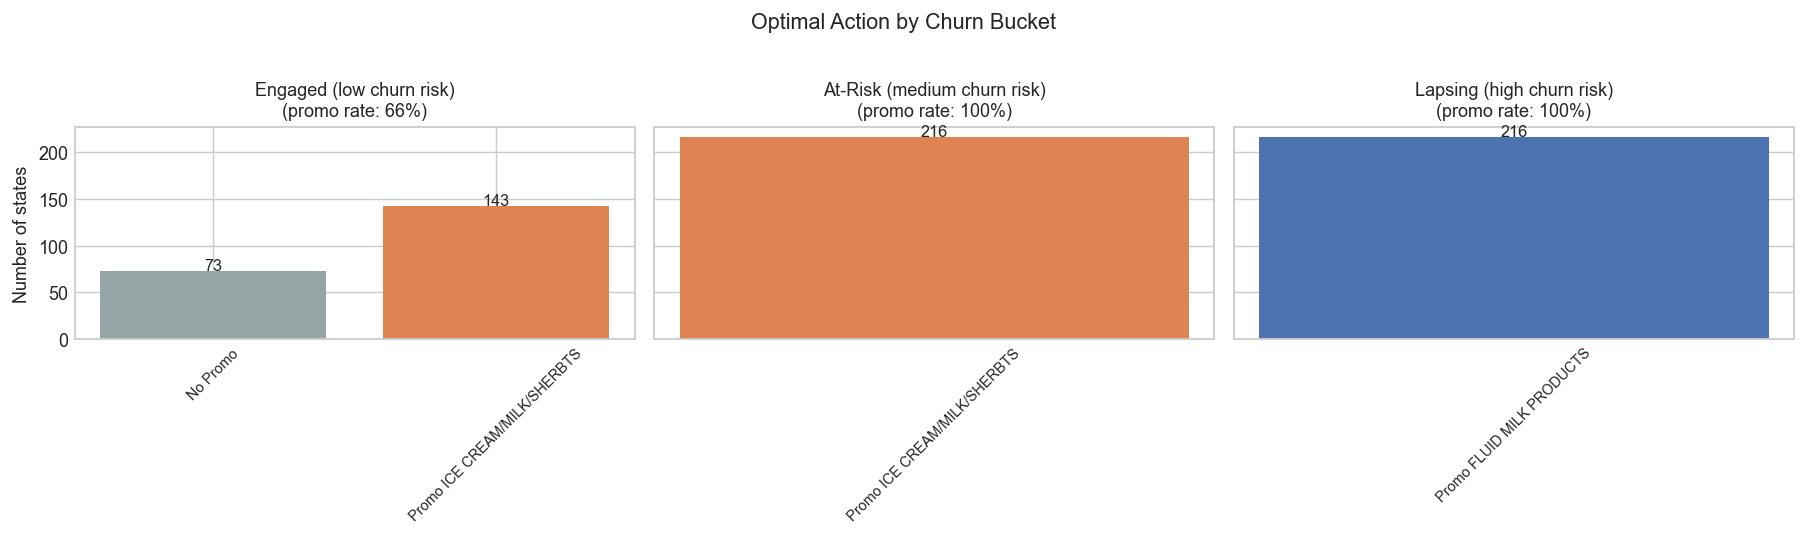

In [9]:
# Action distribution by churn bucket
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
colors = ["#95a5a6", "#4C72B0", "#DD8452", "#55A868"]

for idx, (churn_val, group) in enumerate(policy_df.groupby("churn_bucket")):
    ax = axes[idx]
    counts = group["action"].value_counts().sort_index()
    bars = ax.bar(
        [action_names[a] for a in counts.index],
        counts.values,
        color=[colors[a] for a in counts.index],
    )
    for bar in bars:
        if bar.get_height() > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    str(int(bar.get_height())), ha="center", fontsize=9)
    label = group["churn_label"].iloc[0]
    promo_rate = (group["action"] > 0).mean()
    ax.set_title(f"{label}\n(promo rate: {promo_rate:.0%})", fontsize=10)
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    if idx == 0:
        ax.set_ylabel("Number of states")

fig.suptitle("Optimal Action by Churn Bucket", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

**Why this makes economic sense:**

- **Lapsing → Milk:** At 50% churn probability per week, the priority is getting the customer to buy *anything*. Milk has 82% baseline purchase probability — promoting it is the safest bet to trigger a purchase and reset the churn counter.
- **Engaged/At-Risk → Ice Cream:** These customers are still active, so churn prevention is less urgent. Ice Cream has the highest shelf price ($2.59) and generates the best revenue per promotion event.
- **Frozen Pizza never promoted:** At $2.00 shelf price and $0.60 deal signal, its promotion ROI is dominated by Ice Cream ($2.59, $0.78 deal signal) in every state.
- **No-promo for healthiest Engaged:** The few states where no promotion is optimal are Engaged customers with low memory and low recency — they're buying reliably and don't need intervention.

## 8. Value Function Interpretation

/var/folders/gf/550wq28x3b12kj3pv8149_tr0000gn/T/ipykernel_20486/1723780794.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(churn_groups, labels=labels, patch_artist=True)


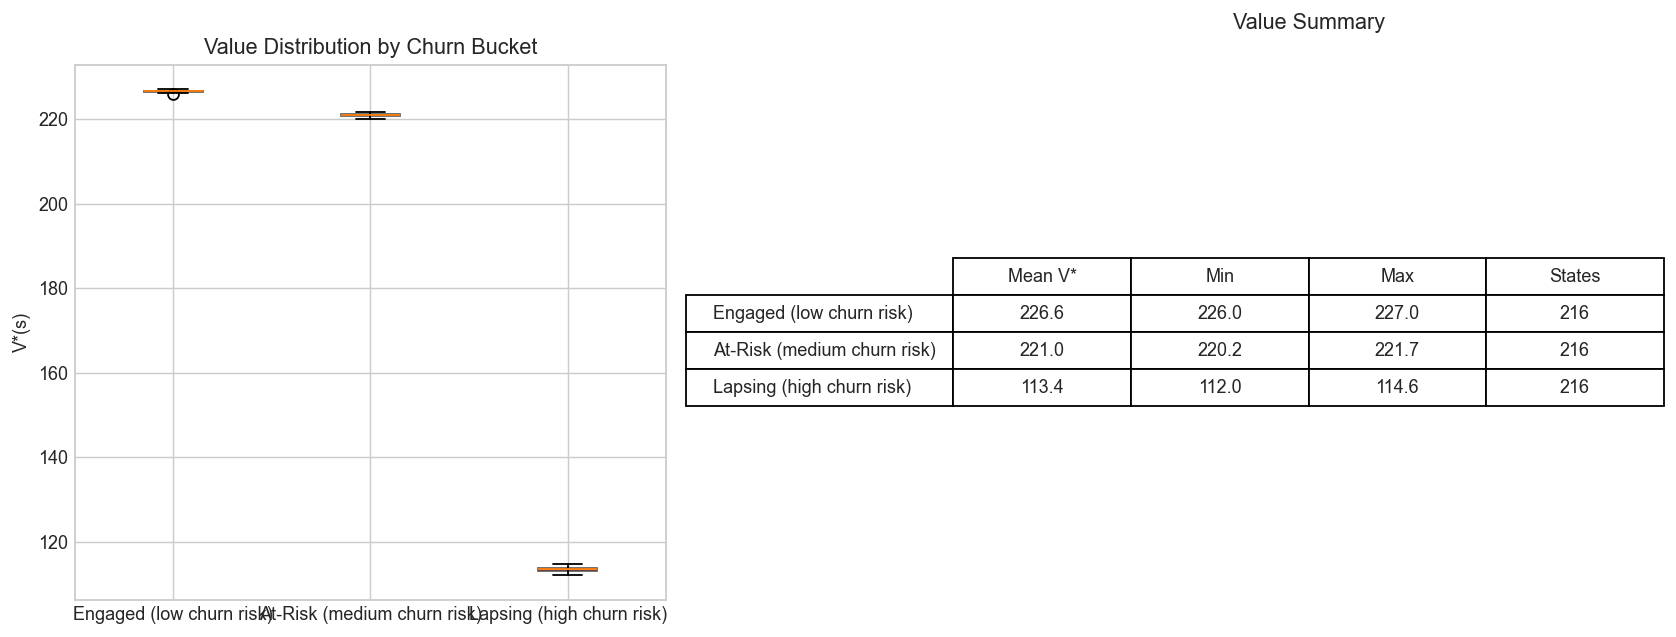


Value of preventing churn: Engaged (226.6) - Lapsing (113.4) = 113.2
This 113-point spread is the long-run cost of a customer lapsing.


In [10]:
# Value distribution by churn bucket
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Box plot
churn_groups = [group["value"].values for _, group in policy_df.groupby("churn_bucket")]
labels = [policy_df[policy_df["churn_bucket"] == i]["churn_label"].iloc[0]
          for i in sorted(policy_df["churn_bucket"].unique())]
bp = ax1.boxplot(churn_groups, labels=labels, patch_artist=True)
box_colors = ["#55A868", "#DD8452", "#C44E52"]
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax1.set_ylabel("V*(s)")
ax1.set_title("Value Distribution by Churn Bucket")

# Summary stats
summary = policy_df.groupby("churn_bucket")["value"].agg(["mean", "min", "max", "count"])
summary.index = [policy_df[policy_df["churn_bucket"] == i]["churn_label"].iloc[0]
                 for i in summary.index]
summary.columns = ["Mean V*", "Min", "Max", "States"]
ax2.axis("off")
table = ax2.table(
    cellText=[[f"{r['Mean V*']:.1f}", f"{r['Min']:.1f}", f"{r['Max']:.1f}", f"{int(r['States'])}"]
              for _, r in summary.iterrows()],
    rowLabels=summary.index,
    colLabels=["Mean V*", "Min", "Max", "States"],
    loc="center",
    cellLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.6)
ax2.set_title("Value Summary", pad=20)

plt.tight_layout()
plt.show()

max_churn = policy_df["churn_bucket"].max()
engaged_mean = policy_df[policy_df["churn_bucket"] == 0]["value"].mean()
lapsing_mean = policy_df[policy_df["churn_bucket"] == max_churn]["value"].mean()
print(f"\nValue of preventing churn: Engaged ({engaged_mean:.1f}) - Lapsing ({lapsing_mean:.1f}) = {engaged_mean - lapsing_mean:.1f}")
print(f"This {engaged_mean - lapsing_mean:.0f}-point spread is the long-run cost of a customer lapsing.")

/var/folders/gf/550wq28x3b12kj3pv8149_tr0000gn/T/ipykernel_20486/814443446.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


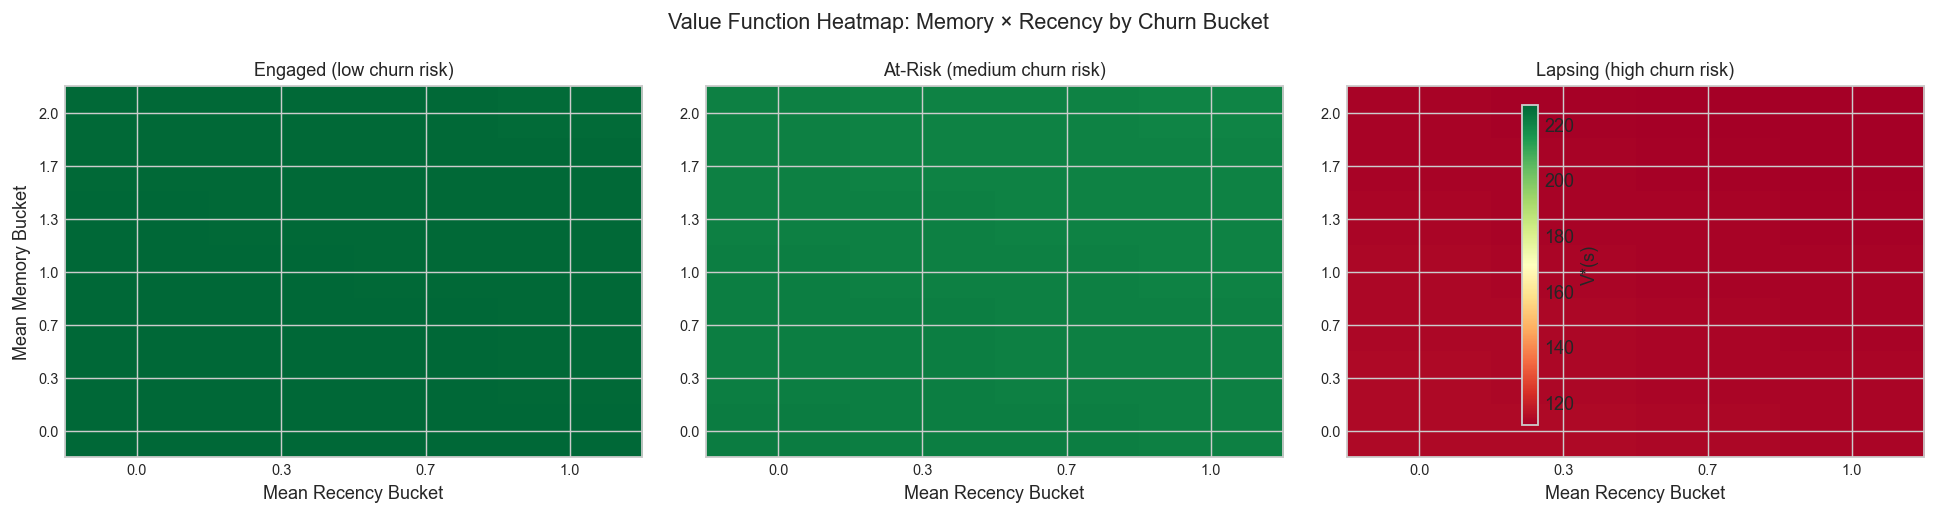

In [11]:
# Heatmap: Mean value by memory × recency for Engaged bucket
engaged = policy_df[policy_df["churn_bucket"] == 0].copy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (churn_val, group) in enumerate(policy_df.groupby("churn_bucket")):
    ax = axes[idx]
    pivot = group.pivot_table(
        values="value", index="memory_mean", columns="recency_mean", aggfunc="mean"
    )
    im = ax.imshow(pivot.values, cmap="RdYlGn", aspect="auto",
                   origin="lower", vmin=policy_df["value"].min(), vmax=policy_df["value"].max())
    ax.set_xlabel("Mean Recency Bucket")
    if idx == 0:
        ax.set_ylabel("Mean Memory Bucket")
    ax.set_title(group["churn_label"].iloc[0], fontsize=10)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{v:.1f}" for v in pivot.columns], fontsize=8)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([f"{v:.1f}" for v in pivot.index], fontsize=8)

fig.colorbar(im, ax=axes, label="V*(s)", shrink=0.8)
fig.suptitle("Value Function Heatmap: Memory × Recency by Churn Bucket", fontsize=12)
plt.tight_layout()
plt.show()

## 9. Q-Gap Diagnostics

The Q-gap measures how much better the optimal action is than the next best alternative.
A small gap means the policy is nearly indifferent; a large gap means the choice is clear.

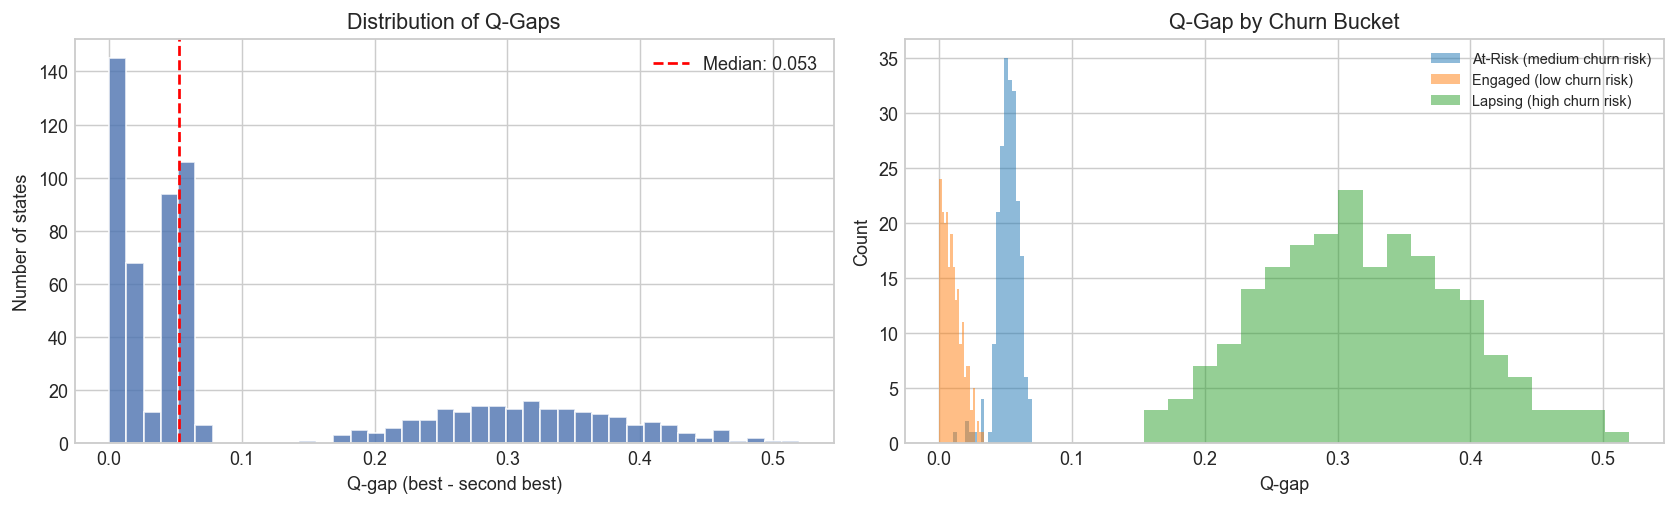

Median Q-gap: 0.0526
Min Q-gap: 0.0002 (nearly indifferent)
Max Q-gap: 0.5198 (strong preference)


In [12]:
# Compute Q-values for all states and actions
q_dict = result.q_values  # dict[DiscreteState, dict[int, float]]
n_actions = N + 1

gaps = []
for i, s in enumerate(live):
    qs = [float(q_dict[s].get(a, 0.0)) for a in range(n_actions)]
    sorted_qs = sorted(qs, reverse=True)
    best = sorted_qs[0]
    second = sorted_qs[1]
    gaps.append({
        "state_idx": i,
        "churn_bucket": policy_df.iloc[i]["churn_bucket"],
        "churn_label": policy_df.iloc[i]["churn_label"],
        "best_action": int(np.argmax(qs)),
        "q_gap": best - second,
        "q_best": best,
        "q_nopromo": qs[0],
    })
gap_df = pd.DataFrame(gaps)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# Q-gap histogram
ax1.hist(gap_df["q_gap"], bins=40, color="#4C72B0", edgecolor="white", alpha=0.8)
ax1.set_xlabel("Q-gap (best - second best)")
ax1.set_ylabel("Number of states")
ax1.set_title("Distribution of Q-Gaps")
ax1.axvline(gap_df["q_gap"].median(), color="red", linestyle="--",
            label=f"Median: {gap_df['q_gap'].median():.3f}")
ax1.legend()

# Q-gap by churn bucket
for label, group in gap_df.groupby("churn_label"):
    ax2.hist(group["q_gap"], bins=20, alpha=0.5, label=label)
ax2.set_xlabel("Q-gap")
ax2.set_ylabel("Count")
ax2.set_title("Q-Gap by Churn Bucket")
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

print(f"Median Q-gap: {gap_df['q_gap'].median():.4f}")
print(f"Min Q-gap: {gap_df['q_gap'].min():.4f} (nearly indifferent)")
print(f"Max Q-gap: {gap_df['q_gap'].max():.4f} (strong preference)")

## 10. Baseline Comparisons

To assess whether the state-conditional policy adds value, we compare against three baselines:
1. **Never promote** (action 0 always)
2. **Always promote the best single category** (the most-used action)
3. **Random uniform** promotion

The overall uplift of the DP policy is modest in percentage terms — this is expected and economically intuitive. The key value is **not** the aggregate number but the **per-segment** story: the DP policy concentrates its advantage in the Lapsing segment where churn risk is highest and the cost of inaction is greatest.

In [13]:
# Evaluate baselines using Q-table
most_common_action = int(policy_df["action"].mode().iloc[0])

baseline_results = {}
for name, action_fn in [
    ("Never Promote", lambda s, i: 0),
    (f"Always {action_names[most_common_action]}", lambda s, i: most_common_action),
    ("Optimal (DP)", lambda s, i: int(result.policy[s])),
]:
    vals = [float(q_dict[s].get(action_fn(s, i), 0.0)) for i, s in enumerate(live)]
    baseline_results[name] = {"mean_v": np.mean(vals), "min_v": np.min(vals), "max_v": np.max(vals)}

# Random: average Q across actions
random_vals = [float(np.mean([q_dict[s].get(a, 0.0) for a in range(n_actions)])) for s in live]
baseline_results["Random Uniform"] = {"mean_v": np.mean(random_vals), "min_v": np.min(random_vals), "max_v": np.max(random_vals)}

baseline_df = pd.DataFrame(baseline_results).T
baseline_df["uplift_vs_never"] = baseline_df["mean_v"] - baseline_df.loc["Never Promote", "mean_v"]
baseline_df["uplift_pct"] = (baseline_df["uplift_vs_never"] / baseline_df.loc["Never Promote", "mean_v"] * 100)
print("=== Overall Baseline Comparison ===")
display(baseline_df.round(4))

# Per-bucket breakdown — reveals where the DP policy adds most value
print("\n=== Per-Bucket Breakdown ===")
bucket_rows = []
for bucket_id, group in policy_df.groupby("churn_bucket"):
    label = group["churn_label"].iloc[0]
    bucket_states = [s for s in live if s.churn_bucket == bucket_id]
    opt_vals = [float(result.values[s]) for s in bucket_states]
    never_vals = [float(q_dict[s][0]) for s in bucket_states]
    best_promo_vals = [float(max(q_dict[s][a] for a in range(1, n_actions))) for s in bucket_states]

    opt_mean = np.mean(opt_vals)
    never_mean = np.mean(never_vals)
    best_promo_mean = np.mean(best_promo_vals)

    bucket_rows.append({
        "Churn Segment": label,
        "n_states": len(bucket_states),
        "V*(optimal)": opt_mean,
        "V(never)": never_mean,
        "V(always best promo)": best_promo_mean,
        "Uplift vs Never": opt_mean - never_mean,
        "Uplift %": (opt_mean - never_mean) / abs(never_mean) * 100,
    })

bucket_df = pd.DataFrame(bucket_rows).set_index("Churn Segment")
display(bucket_df.round(4))

=== Overall Baseline Comparison ===


,mean_v,min_v,max_v,uplift_vs_never,uplift_pct
Never Promote,186.6795,110.9565,227.0487,0.0000,0.0000
Always Promo ICE CREAM/MILK/SHERBTS,186.8685,111.4660,227.0243,0.1890,0.1012
Optimal (DP),186.9757,111.9858,227.0487,0.2962,0.1587
Random Uniform,186.7998,111.4359,226.9464,0.1202,0.0644



=== Per-Bucket Breakdown ===


,n_states,V*(optimal),V(never),V(always best promo),Uplift vs Never,Uplift %
Churn Segment,,,,,,
Engaged (low churn risk),216,226.5642,226.5565,226.5616,0.0077,0.0034
At-Risk (medium churn risk),216,220.9769,220.8521,220.9769,0.1248,0.0565
Lapsing (high churn risk),216,113.3860,112.6300,113.3860,0.7560,0.6712


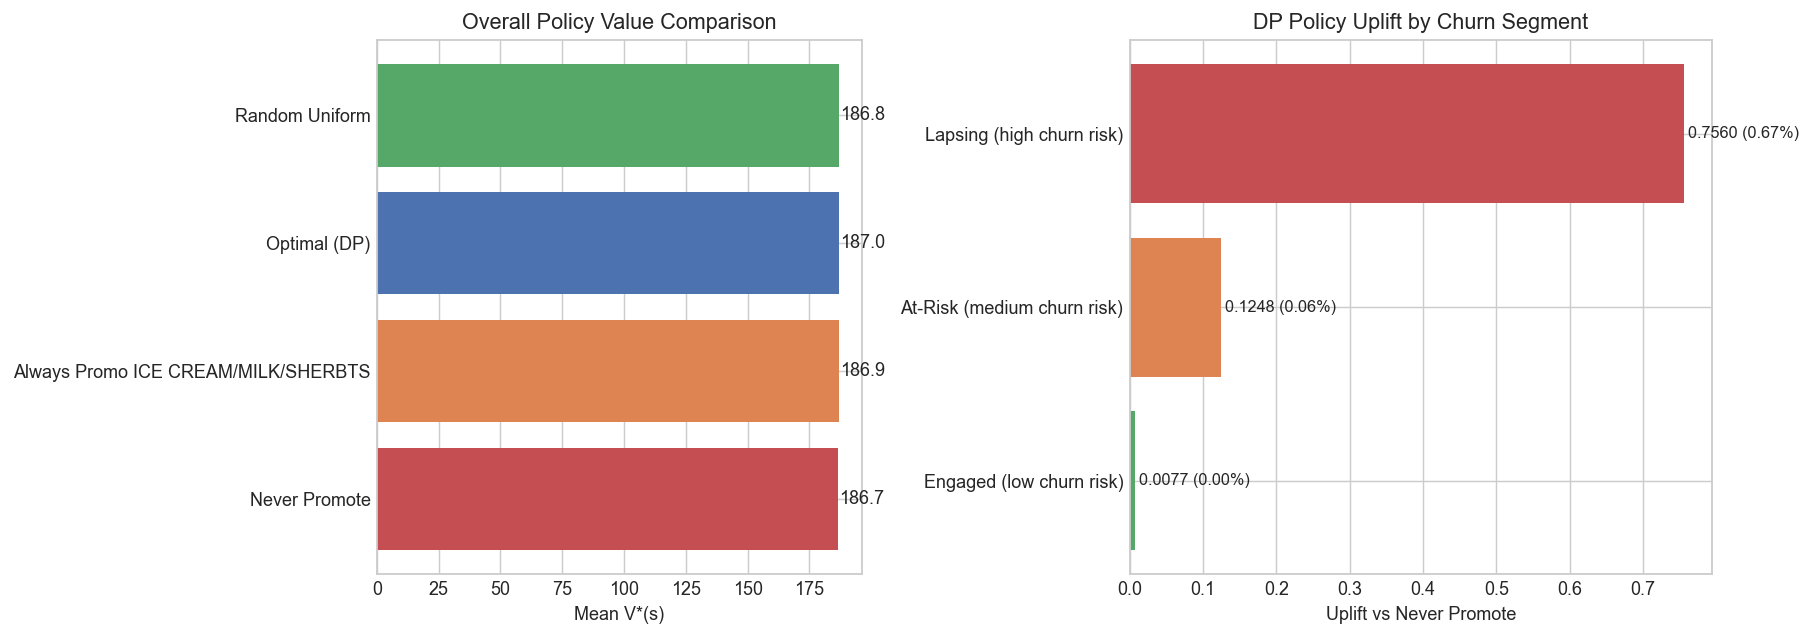

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"width_ratios": [1, 1.2]})

# Left panel: overall policy comparison
ax = axes[0]
names_bl = list(baseline_results.keys())
means = [baseline_results[n]["mean_v"] for n in names_bl]
bar_colors = ["#C44E52", "#DD8452", "#4C72B0", "#55A868"]
bars = ax.barh(names_bl, means, color=bar_colors[:len(names_bl)])
for bar, val in zip(bars, means):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f"{val:.1f}", va="center", fontsize=10)
ax.set_xlabel("Mean V*(s)")
ax.set_title("Overall Policy Value Comparison")

# Right panel: per-segment uplift
ax2 = axes[1]
segments = list(bucket_df.index)
uplift_vals = bucket_df["Uplift vs Never"].values
uplift_pcts = bucket_df["Uplift %"].values
seg_colors = ["#55A868", "#DD8452", "#C44E52"][:len(segments)]
bars2 = ax2.barh(segments, uplift_vals, color=seg_colors)
for bar, val, pct in zip(bars2, uplift_vals, uplift_pcts):
    ax2.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{val:.4f} ({pct:.2f}%)", va="center", fontsize=9)
ax2.set_xlabel("Uplift vs Never Promote")
ax2.set_title("DP Policy Uplift by Churn Segment")

plt.tight_layout()
plt.show()

## 11. Memory Sensitivity Analysis

The calibration found that `beta_m` (memory penalty for past promotions) is essentially zero for these categories — the data shows no reference-price erosion effect for ice cream, frozen pizza, or milk.

This is a genuine finding: the Phase 1 theory that "repeated promotions erode willingness to pay" doesn't show up in the Dunnhumby data for these categories. For alpha ≥ 0.3, the optimizer actually tries to make `beta_m` **negative** (past deals *increase* future purchases — habit formation), hitting the non-negativity constraint.

To explore what the policy *would* look like if reference-price effects exist but are too noisy to measure, we impose a `beta_m_floor = 0.10`.

The floor is configured in `configs/data/calibration.yaml` and can be disabled by setting `beta_m_floor: null`.

In [15]:
# Load evaluation summaries from both runs
def load_eval(run_dir):
    with open(run_dir / "evaluation_summary.json") as f:
        return json.load(f)

eval_nofloor = load_eval(RUN_V3_NOFLOOR)
eval_floor = load_eval(RUN_V3_FLOOR)

comparison = pd.DataFrame({
    "Metric": ["beta_m", "Actions used", "Overall promo rate",
               "Engaged promo rate", "At-Risk promo rate", "Lapsing promo rate",
               "No-promo states"],
    "Fitted (no floor)": [
        "0.006",
        str(len(eval_nofloor["policy_cluster_summary"]["action_histogram"])),
        f"{eval_nofloor['policy_cluster_summary']['promotion_rate']:.1%}",
        f"{eval_nofloor['policy_cluster_summary']['by_churn_bucket']['0']['promotion_rate']:.1%}",
        f"{eval_nofloor['policy_cluster_summary']['by_churn_bucket']['1']['promotion_rate']:.1%}",
        f"{eval_nofloor['policy_cluster_summary']['by_churn_bucket']['2']['promotion_rate']:.1%}",
        str(eval_nofloor["policy_cluster_summary"]["action_histogram"].get("0", 0)),
    ],
    "Floor = 0.10": [
        "0.100",
        str(len(eval_floor["policy_cluster_summary"]["action_histogram"])),
        f"{eval_floor['policy_cluster_summary']['promotion_rate']:.1%}",
        f"{eval_floor['policy_cluster_summary']['by_churn_bucket']['0']['promotion_rate']:.1%}",
        f"{eval_floor['policy_cluster_summary']['by_churn_bucket']['1']['promotion_rate']:.1%}",
        f"{eval_floor['policy_cluster_summary']['by_churn_bucket']['2']['promotion_rate']:.1%}",
        str(eval_floor["policy_cluster_summary"]["action_histogram"].get("0", 0)),
    ],
})
display(comparison.style.hide(axis='index').set_caption("Memory Sensitivity: Fitted vs. Floor"))

Metric,Fitted (no floor),Floor = 0.10
beta_m,0.006,0.100
Actions used,3,3
Overall promo rate,99.2%,88.7%
Engaged promo rate,97.7%,66.2%
At-Risk promo rate,100.0%,100.0%
Lapsing promo rate,100.0%,100.0%
No-promo states,5,73


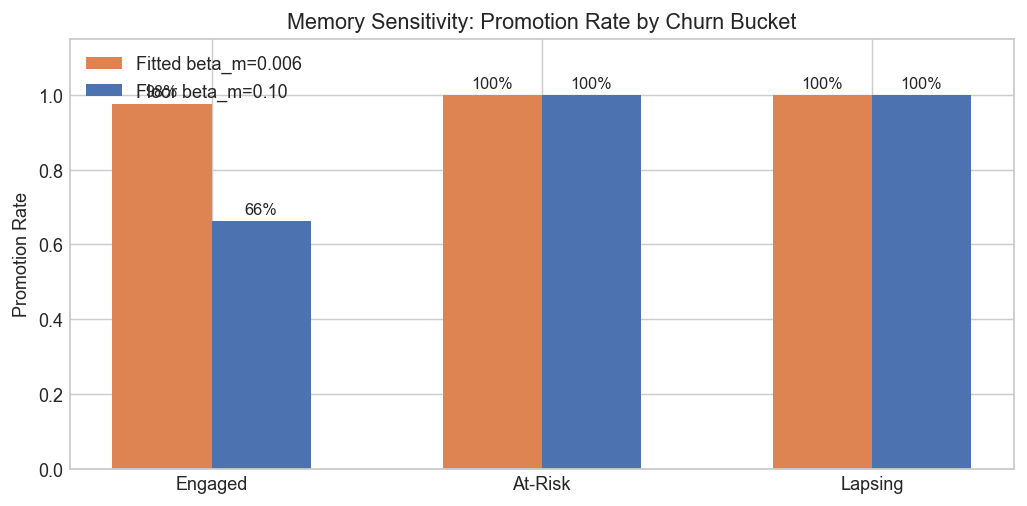

In [16]:
# Visual comparison of promotion rates by churn bucket
fig, ax = plt.subplots(figsize=(8, 4))

bucket_labels = ["Engaged", "At-Risk", "Lapsing"]
nofloor_rates = [eval_nofloor["policy_cluster_summary"]["by_churn_bucket"][str(i)]["promotion_rate"]
                 for i in range(3)]
floor_rates = [eval_floor["policy_cluster_summary"]["by_churn_bucket"][str(i)]["promotion_rate"]
               for i in range(3)]

x = np.arange(len(bucket_labels))
width = 0.3
bars1 = ax.bar(x - width/2, nofloor_rates, width, label="Fitted beta_m=0.006", color="#DD8452")
bars2 = ax.bar(x + width/2, floor_rates, width, label="Floor beta_m=0.10", color="#4C72B0")

ax.set_ylabel("Promotion Rate")
ax.set_title("Memory Sensitivity: Promotion Rate by Churn Bucket")
ax.set_xticks(x)
ax.set_xticklabels(bucket_labels)
ax.legend()
ax.set_ylim(0, 1.15)
for bar in list(bars1) + list(bars2):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f"{bar.get_height():.0%}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()

**Key observations from the sensitivity analysis:**

1. **The floor only affects Engaged customers.** At-Risk and Lapsing still promote 100% — churn risk dominates any memory concern.
2. **Engaged promotion drops from 98% → 66%.** With a meaningful memory penalty, the DP withholds promotion from customers who are already buying reliably and have low deal-memory exposure.
3. **The memory addiction warning returns.** High-memory customers are promoted at 100% vs. low-memory at 72%. This is the "discount trap": once you've built up a customer's deal expectations, withdrawing promotions risks losing them.
4. **Both policies use 3 of 4 actions** and maintain the same strategic structure (Milk for Lapsing, Ice Cream for active customers).

**For the submission:** The floor is a sensitivity knob. Set `beta_m_floor: null` in `configs/data/calibration.yaml` to use the pure fitted value. The contrast between floor and no-floor policies is itself a finding worth discussing.

## 12. Quality Checks

In [17]:
with temporary_bucket_grids(
    memory_grid=np.array(MEMORY_GRID),
    recency_grid=np.array(RECENCY_GRID),
):
    qc_report = run_quality_checks(
        params=params,
        values=result.values,
        policy=result.policy,
        q_values=result.q_values,
        gamma=vi_config.gamma,
        strict_conceptual=False,
    )

hard_fails = qc_report.hard_failures
concept_warns = qc_report.conceptual_warnings
if not hard_fails and not concept_warns:
    print("All quality checks passed.")
else:
    if hard_fails:
        print(f"Hard failures ({len(hard_fails)}):")
        for w in hard_fails:
            print(f"  - {w.name}: {w.details}")
    if concept_warns:
        print(f"Conceptual warnings ({len(concept_warns)}):")
        for w in concept_warns:
            print(f"  - {w.name}: {w.details}")

Conceptual warnings (1):
  - memory_addiction_intuition: promotion_rate(high_memory)=1.000, promotion_rate(low_memory)=0.719


## 13. Key Takeaways

### What the DP found

1. **Category type determines promotion strategy.** Staples (Milk) are promoted only as a last-resort churn intervention. Discretionary items (Ice Cream) are the primary promotion vehicle because they generate genuine incremental purchases.

2. **Churn prevention dominates immediate revenue.** Every promotion is immediately unprofitable (the 30% discount costs more than the purchase uplift). The DP promotes anyway because keeping customers engaged is worth ~113 more in long-run value than letting them lapse.

3. **Memory effects are category-dependent.** The calibration found no reference-price erosion for these categories (beta_m → 0). This contradicts the Phase 1 theory but matches economic intuition for discretionary/impulse items where promotions act as reminders rather than anchors.

4. **Time resolution matters enormously.** Switching from daily to weekly aggregation transformed churn from "didn't shop today" (trivial) to "didn't shop this week" (meaningful signal), making the DP's planning horizon 7× more effective.

### Analytical decisions documented

| Decision | Rationale | Reference |
|----------|-----------|----------|
| Weekly aggregation | Daily resolution suppressed churn/recency dynamics | `specs/05_staple_daily_resolution_findings.md` |
| Mixed categories | Staple-only set produced trivially conservative policy | `specs/phase2_audit.md` #3 |
| `price_delta_dollars` contract | Aligns calibration and DP deal signal units | `specs/phase2_audit.md` #1 |
| `beta_m_floor = 0.10` | Sensitivity knob; set to `null` for pure fitted values | `configs/data/calibration.yaml` |
| Recency grid `[1.0, 4.0]` | Calibrated for weekly time scale (weeks since last purchase) | `configs/dp/solver.yaml` |

### Run artifact index

| Run | Description | Key result |
|-----|-------------|------------|
| `runs/dp/20260218_083313_weekly_mixed_v3` | Weekly, mixed, no floor | 99.2% promo, 3/4 actions, 0 warnings |
| `runs/dp/20260218_084945_weekly_mixed_v3_floor` | Weekly, mixed, floor=0.10 | 88.7% promo, 3/4 actions, 1 warning |
| `runs/dp/20260218_074830_contract_default` | Daily, staples, deal-signal fix | 6.8% promo, 2/4 actions |